In [2]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
import time
from time import time
import re
from sklearn.model_selection import train_test_split

This below blocks are for obtaining the question1, question2 out of the data files. When in development, we use train_test_split on train.csv, and train the CNN based on train part, and verify based on dev part. This is doing a proof of concept that the CNN can work in detecting dup questions.  

However when trying to apply the trained CNN to the test data set, we use the entire train.csv to retrain the CNN, and then apply to the test data set. In this case, we do not use a train_test_split. 

In [3]:
def form_training_data(filename, test_size=0.0):
    df = pd.read_csv(filename).fillna("")
    if test_size==0.0:
        return df, None
    else:
        #only when developing I use this, if not I directly use the whole training set
        df_train, df_dev= train_test_split(df, test_size=test_size)
        return df_train, df_dev  

In [4]:
df_train, df_dev= form_training_data("train.csv")
#df_train, df_dev= form_training_data("train.csv", test_size=0.3)

In [5]:
def prepare_data(df):
    df_q1 = df["question1"]
    df_q2 = df["question2"]

    df_concat = pd.concat((df_q1, df_q2), axis=0).fillna("")
    df_concat.columns = ["question"]

    sentences = [word_tokenize(sent) for sent in df_concat]
    num_pairs = df.shape[0]
    q1_sents = sentences[0:num_pairs]
    q2_sents = sentences[num_pairs:]
    return q1_sents, q2_sents, sentences

In [6]:
q1_sents_train, q2_sents_train, sents_train = prepare_data(df_train)
lbls_train = df_train["is_duplicate"]

The below block is training a word2vec embedding based on train.csv, which will be used in the embedding layer of the CNN. 

In [ ]:
#train word2vec
import gensim 
from gensim.models import Word2Vec
w2v_model = Word2Vec(min_count = 5, size = 100, window = 4, sg = 1, negative = 20)
t = time()

w2v_model.build_vocab(sents_train)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

t = time()

w2v_model.train(sents_train, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
#save word2vec
w2v_model.wv.save_word2vec_format("w2v_text",binary=False)

In [ ]:
#load word2vec
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load("w2v_test", mmap='r')
wv_from_text = KeyedVectors.load_word2vec_format("w2v_text", binary=False)

In [ ]:
#testing the trained word2vec
result = word_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))
result = word_vectors.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))
print(word_vectors.doesnt_match("breakfast cereal dinner lunch".split()))
similarity = word_vectors.similarity('woman', 'man')
print(similarity)
result = word_vectors.similar_by_word("cat")
print("{}: {:.4f}".format(*result[0]))
distance = word_vectors.wv.distance("media", "media")
print("{:.1f}".format(distance))
sim = word_vectors.n_similarity(['sushi', 'shop'], ['japanese', 'restaurant'])
print("{:.4f}".format(sim))
vector = word_vectors['computer']  # numpy vector of a word
print(vector.shape)
vector = word_vectors.wv.word_vec('office', use_norm=True)
print(vector.shape)

The below blocks are trying to do all sorts of preparation in order to feed the data into the CNN

In [7]:
MIN_COUNT = 20
def create_encoder(text, min_count=20):
    """
    - Create a encoder which is a dictionary like {word: index}
    - To reduce the total number of vocabularies, you can remove 
    the words that appear for less than min_count times in the entire
    corpus
    - Enfore {'_unknown_': 0}
    
    input:
        text: list of token list, e.g. [['i', 'am', 'fine'], ['another', 'summary'], ...]
    returns:
        tokenmap:  encoder dictionary
        tokenmap_reverse: reversed tokenmap {index: word} to faciliate inverse lookup
    """
    tokenmap = {'_unknown_': 0}
    tokenmap_reverse = {0: '_unknown_'}
    
    w_count = {}
    unique_idx = 1
    for s in text:
        for w in s:
            w_count[w] = w_count.get(w, 0) + 1
            if w not in tokenmap and w_count[w] >= min_count:
                tokenmap[w] = unique_idx
                tokenmap_reverse[unique_idx] = w
                unique_idx += 1

    return tokenmap, tokenmap_reverse

In [8]:
tokenmap, tokenmap_reverse = create_encoder(sents_train, min_count=5)
VOCAB_SIZE = len(tokenmap)
MAX_LENGTH = 200
print("the reduced vocabulary size is:", VOCAB_SIZE)

the reduced vocabulary size is: 37122


In [9]:
def trim_X(X, max_length=100, default=tokenmap['?']):
    for i in range(len(X)):
        if len(X[i]) > max_length:
            X[i] = X[i][:max_length]
        elif len(X[i]) < max_length:
            X[i] = X[i] + [default] * (max_length - len(X[i]))
            
    return np.array(X)

In [10]:
def encode_data(q1_sents, q2_sents, unknown=tokenmap['_unknown_'], default=tokenmap['?'], max_length=100):
    q1_num_encoded = [[tokenmap.get(w1, unknown) for w1 in sent1] for sent1 in q1_sents]
    q2_num_encoded = [[tokenmap.get(w2, unknown) for w2 in sent2] for sent2 in q2_sents]
    q1_num_encoded = trim_X(q1_num_encoded, max_length=max_length,default=default)
    q2_num_encoded = trim_X(q2_num_encoded, max_length=max_length,default=default)
    return q1_num_encoded, q2_num_encoded

In [11]:
q1_num_encoded, q2_num_encoded = encode_data(q1_sents_train, q2_sents_train, max_length=MAX_LENGTH)

In [12]:
def training_data_generator(q1_num_encoded, q2_num_encoded, lbls, batch_docs=50, strangle=False):
    if q1_num_encoded.shape != q2_num_encoded.shape:
        print("dimensions do not match")
    batch_count = 0
    num_pairs = q1_num_encoded.shape[0]
    for i in range(num_pairs):
        batch_count += 1
        if batch_count == batch_docs:
            q1_encoded = q1_num_encoded[i+1-batch_docs:i+1]
            q2_encoded = q2_num_encoded[i+1-batch_docs:i+1]
            labels = np.array(lbls[i+1-batch_docs:i+1])
            batch_count = 0
            yield q1_encoded, q2_encoded, labels
    if strangle and batch_count != 0:
        q1_encoded = q1_num_encoded[num_pairs-batch_count:]
        q2_encoded = q2_num_encoded[num_pairs-batch_count:]
        labels = np.array(lbls[num_pairs-batch_count:])
        yield q1_encoded, q2_encoded, labels

The below blocks read the pre-trained word2vec embedding and based on the current vocabulary form the embedding matrix that we will use in the CNN embedding layer. 

In [13]:
#my own trained word2vec
embedding_file = "w2v_text"
f = open(embedding_file,"rb")
embeddings_index = {}
i = 0
for line in f:
    if i == 0:
        i += 1
        continue
    values = line.split()
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
    i += 1
f.close()
print("found {} words in embedding matrix".format(i-1))

found 37121 words in embedding matrix


In [14]:
embedding_matrix = np.zeros((VOCAB_SIZE, 100))
for word, i in tokenmap.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Form the CNN in the below blocks. This CNN takes in two inputs, the numerically encoded sentences, question1, and question2 for each question pair. Then, it runs through an embedding layer to form the distributed representation of each sentence. Then, it runs through a convolutional layer as well as a max pooling layer. Then, the vector representation of the two sentences are calculated for a cosine distance, and use an activation function to form either true or false. 

In [15]:
#build the CNN here
from keras.layers import Input, Dense, Embedding, Reshape, Dot,Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.models import Model
import random, string, os
from keras.utils import plot_model
from IPython.display import Image

def show_model(model):
    filename = "".join(random.choices(string.ascii_uppercase, k=10)) + ".png"
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=True)
    image = Image(filename)
    os.remove(filename)
    return image

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


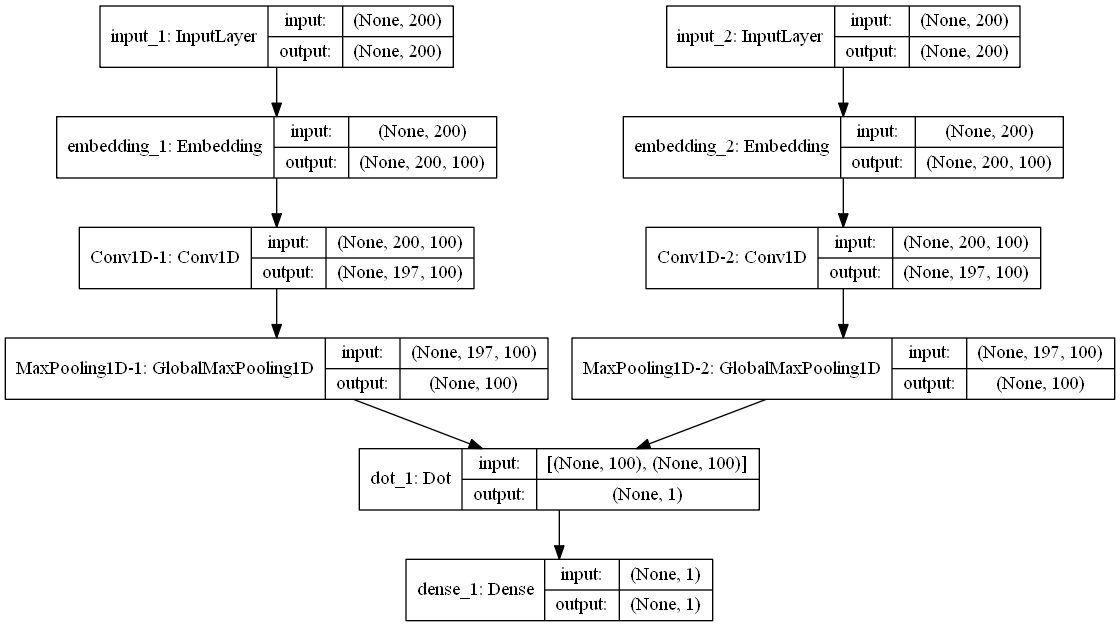

In [16]:
input_1 = Input(shape=(MAX_LENGTH,), dtype='int32', name='input_1')
x1 = Embedding(output_dim=100, input_dim=VOCAB_SIZE, weights=[embedding_matrix], 
               input_length=MAX_LENGTH, name='embedding_1')(input_1)
x1 = Conv1D(filters=100, kernel_size=4, activation="tanh", name="Conv1D-1")(x1)
x1 = GlobalMaxPooling1D(name="MaxPooling1D-1")(x1)
input_2 = Input(shape=(MAX_LENGTH,), dtype='int32', name='input_2')
x2 = Embedding(output_dim=100, input_dim=VOCAB_SIZE, weights=[embedding_matrix],
               input_length=MAX_LENGTH, name='embedding_2')(input_2)
x2 = Conv1D(filters=100, kernel_size=4, activation="tanh", name="Conv1D-2")(x2)
x2 = GlobalMaxPooling1D(name="MaxPooling1D-2")(x2)
dot_prod = Dot(axes=1,normalize=True)([x1, x2])
output = Dense(1, activation="sigmoid")(dot_prod)
model = Model(inputs=[input_1, input_2], outputs=[output])
model.compile(loss="binary_crossentropy", metrics = ['binary_accuracy'],optimizer="rmsprop")
show_model(model)

In [ ]:
epochs = 10
ntot = 0
for epoch in range(epochs):
    print("Epoch %d ======" % epoch)
    for q1_encoded, q2_encoded, labels in training_data_generator(q1_num_encoded, q2_num_encoded, lbls_train, batch_docs=50):
        loss, acc = model.train_on_batch(x=[q1_encoded, q2_encoded], y=labels)
        ntot += len(q1_encoded)
        print("Total trained pairs (M): %10.2f ; \t loss: %.4f; acc: %.4f" % (ntot/1e6, loss,acc))

In [ ]:
from datetime import datetime

dt = datetime.today().strftime("%Y%m%d%H%M")
model.save("keras_CNN_{}".format(dt))

Load the trained CNN. 

In [17]:
from keras.models import load_model
loaded_model = load_model("keras_CNN_201905281745")

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


The below blocks are when I was developing, to verify if the CNN does work, I use 30% of train.csv to test out if the result is good. The accuracy is around 0.76 to 0.83. The output is too many so I cleared it on jupyter notebook. But, I have manually pasted it to a file which contained the evaluation results. 

In [ ]:
# this is used when I was doing development, as mentioned above. 
df_train, df_dev = form_training_data("train.csv",test_size=0.3)
q1_sents_dev, q2_sents_dev, sents_dev = prepare_data(df_dev)
q1_num_encoded_dev, q2_num_encoded_dev = encode_data(q1_sents_dev, q2_sents_dev, max_length=MAX_LENGTH)
lbls_dev = df_dev["is_duplicate"]

In [ ]:
#this is only for dev purpose, when confirming the model trained is good enough. 
ntot = 0
for q1_encoded, q2_encoded, labels in training_data_generator(q1_num_encoded_dev, q2_num_encoded_dev, lbls_dev, batch_docs=50):
    #loss = model.test_on_batch(x=[q1_encoded, q2_encoded], y=labels)
    loss, acc = loaded_model.evaluate(x=[q1_encoded, q2_encoded], y=labels)
    ntot += len(q1_encoded)
    print("Total trained pairs (M): %10.2f ; \t loss: %.4f; acc: %.4f;" % (ntot/1e6, loss, acc))

The below blocks are to use the trained CNN to generate similarity scores that Tengbo will use as features in his training. Pop out the last layer and you can directly output similarity score with the CNN. We collected both the scores of train.csv and test.csv. 

In [ ]:
#df_test, a = form_training_data("train.csv")
df_test, a = form_training_data("test.csv")
q1_sents_test, q2_sents_test, sents_test = prepare_data(df_test)
q1_num_encoded_test, q2_num_encoded_test = encode_data(q1_sents_test, q2_sents_test, max_length=MAX_LENGTH)

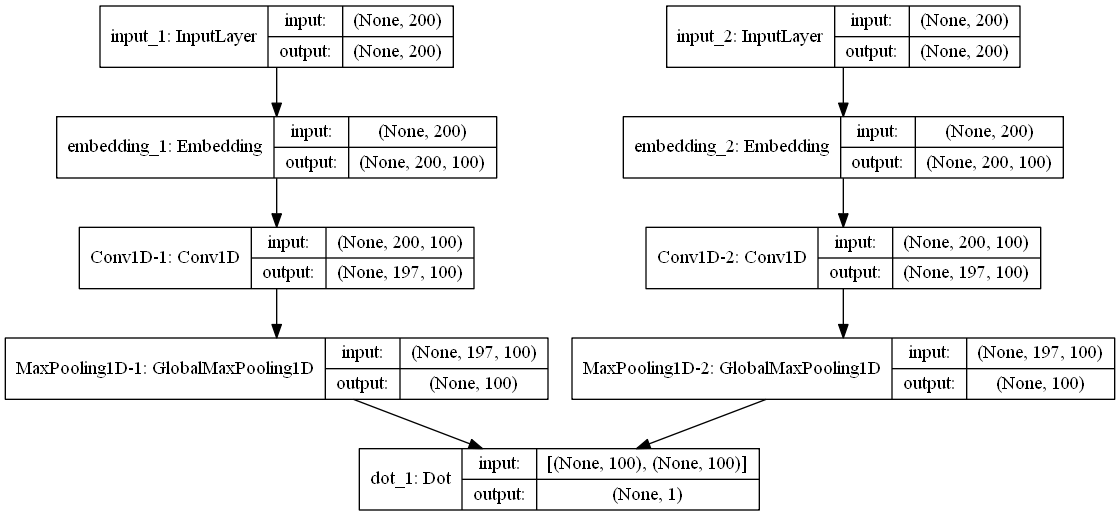

In [19]:
loaded_model.layers.pop()
loaded_model.build(None)
show_model(loaded_model)

In [ ]:
import csv

In [ ]:
length = len(q1_num_encoded_test)
print(length)
test_ids = df_test["test_id"]
#test_ids = df_test["id"] # if using train.csv
ntot = 0
with open("sh_similarity.csv", "w") as csv_file:
    csv_writer = csv.writer(csv_file,delimiter=",")
    csv_writer.writerow(["test_id","similarity"])
    for q1_encoded, q2_encoded, test_id in training_data_generator(q1_num_encoded_test, q2_num_encoded_test, test_ids, batch_docs=1, strangle=True):
        similarity = loaded_model.predict(x=[q1_encoded, q2_encoded])
        csv_writer.writerow([test_id,similarity])
        ntot += 1
        if ntot % 100000 == 0:
            print(ntot)

In [ ]:
df_sim_test = pd.read_csv("sh_similarity.csv")
df_sim_test.head()